In [3]:
import os
import numpy as np
import rasterio

import cv2
import matplotlib.pyplot as plt
import geopandas as gpd

from rasterio.mask import mask
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

from shapely.geometry import mapping, Polygon
from shapely.ops import unary_union

PATCH_WIDTH = 128

Reading raster files

In [6]:
raster_path = "data/T36UXV_20200406T083559_TCI_10m.jp2"

with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta

In [7]:
print(raster_img.shape)

(3, 10980, 10980)


In [8]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5500020.0)}

Reshaping rasters

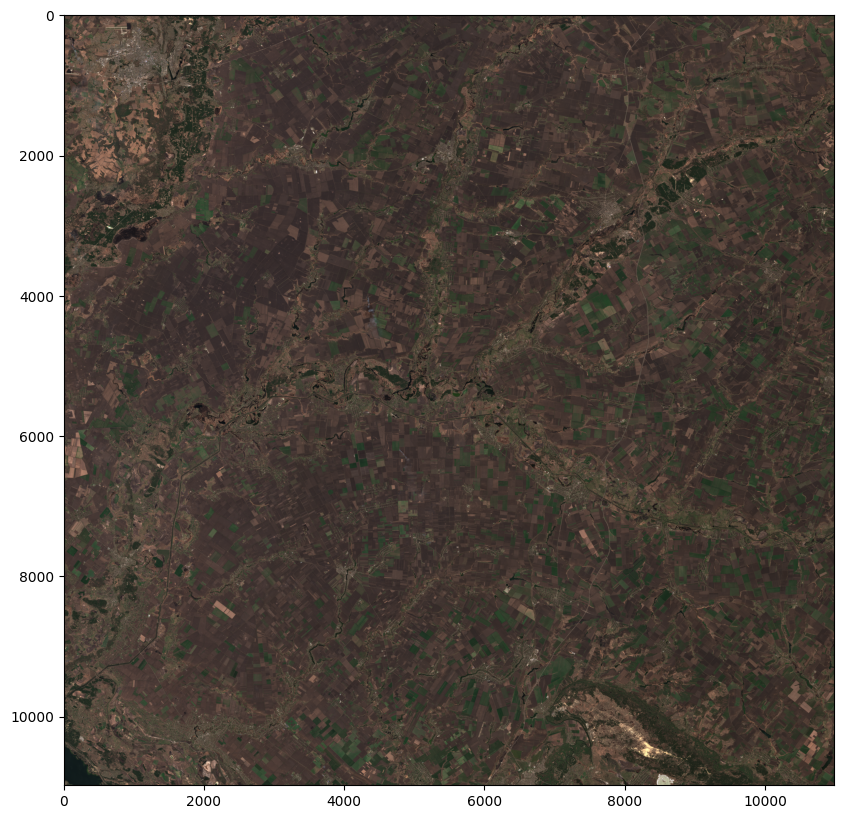

In [9]:
raster_img_reshaped = reshape_as_image(raster_img)

plt.figure(figsize=(10,10))
plt.imshow(raster_img_reshaped)

In [10]:
train_df = gpd.read_file("data/masks/Masks_T36UXV_20190427.shp")

print(train_df.shape)
train_df.head(5)

(936, 7)


,id,Data,Code,Descriptio,Comments,Image,geometry
0,NaN,NaN,2.0,branch of tree,NaN,T36UXV_20190427T083601,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,NaN,NaN,2.0,brahch of tree,NaN,T36UXV_20190427T083601,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."
4,NaN,NaN,1.0,color+ feathers,NaN,T36UXV_20190427T083601,"POLYGON ((35.60455 49.61078, 35.60597 49.61228..."


Checking coordinates of polygon using Polygon methods

In [11]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

Trying to cut fields from Raster

In [12]:
src = rasterio.open(raster_path, 'r')
failed = []

for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(
            src, [mapping(row['geometry'])], crop=True, nodata=0
        )
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 936 files


Rasterio failed to mask the data because .shp CRS doesn't match the CRS of the raster. We need to convert them manually

The best match according to projfinder is <b>EPSG:4200 Name:Pulkovo 1995</b> So we will use it for transformation

Converting GeoDataframe to raster CRS

In [13]:
# Removing rows without geometry
train_df = train_df[train_df.geometry.notnull()]
# Assigning crs
train_df.crs = {'init': 'epsg:4200'}

# transforming polygons to the raster crs
train_df = train_df.to_crs({'init': raster_meta['crs']['init']})

c:\Users\nazar\anaconda3\envs\ml-intro\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [15]:
src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = "data/images_cropped_rgb"
os.makedirs(outfolder, exist_ok=True)
failed = []


for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = mask(
            src, [mapping(row['geometry'])], crop=True, nodata=0
        )
        img_image= reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(num) + '.png')
        img_image= cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, img_image)
    except Exception as e:
        #print(e)
        failed.append(num)

print(f"Rasterio failed to mask {len(failed)} files")

Rasterio failed to mask 434 files


Data Preparation

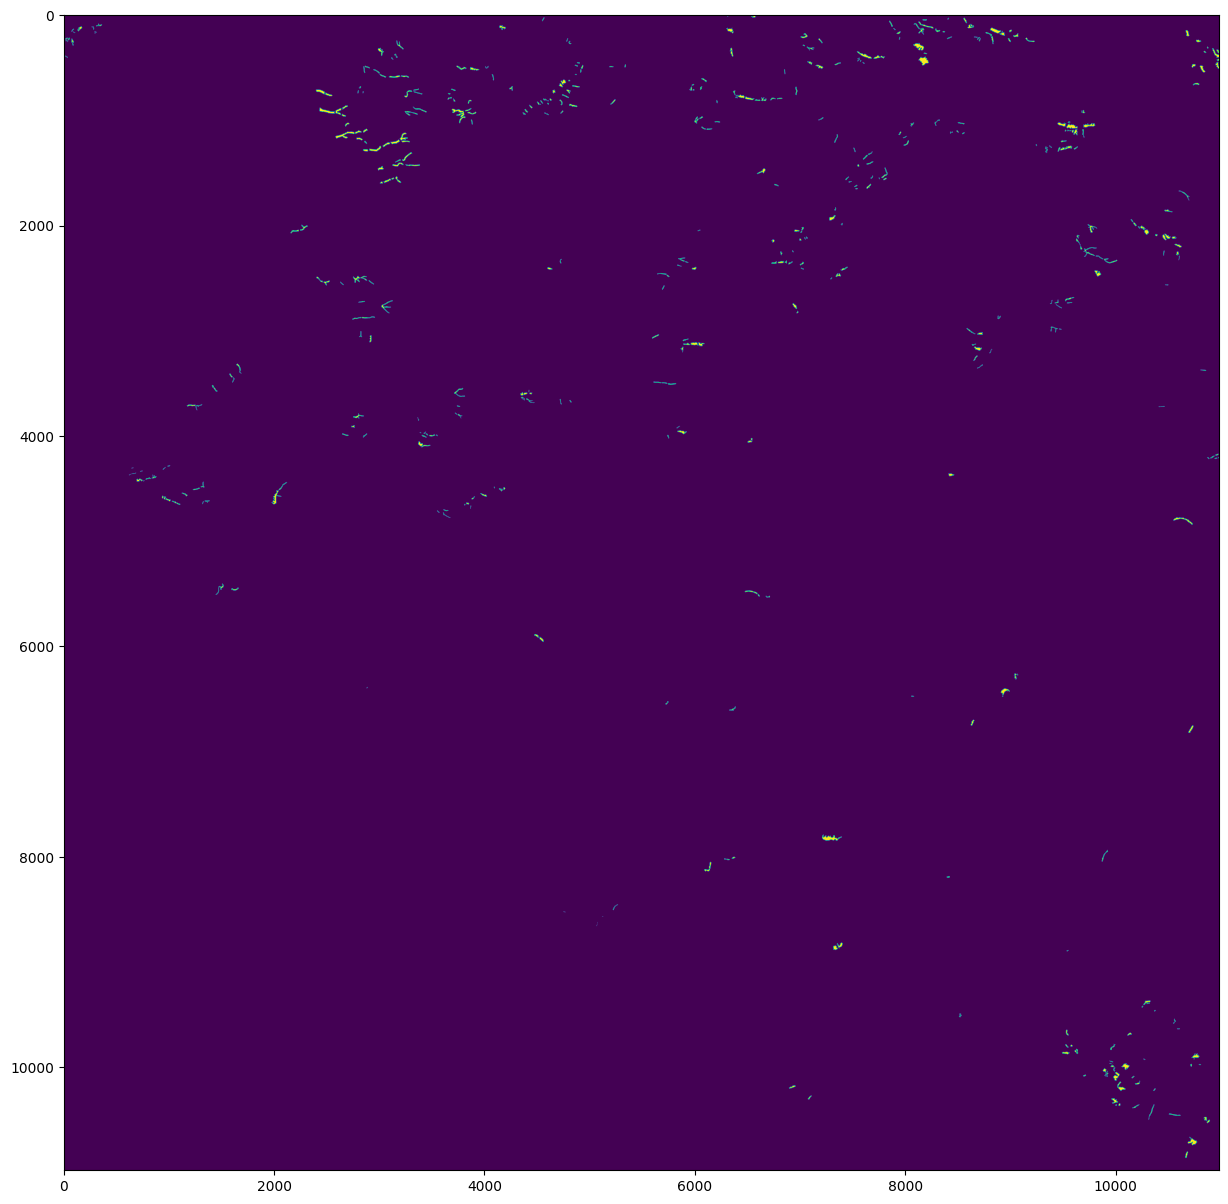

In [16]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts=[]

    # make a polygon from multipolygon
    poly = unary_union(polygon)
    for i in np.array(poly.exterior.coords):

        # transform polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))

    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_field segmentation

poly_shp = []
img_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])

mask = rasterize(shapes=poly_shp,
                out_shape=img_size)

# plotting the mask
plt.figure(figsize=(15, 15))
plt.imshow(mask)

Saving binary mask for training

In [ ]:
# Updating Meta Data
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})

with rasterio.open("data/train.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)